In [2]:
cd /content/drive/MyDrive/Facial emotion recognition by AK

/content/drive/MyDrive/Facial emotion recognition by AK


In [3]:

import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import cv2
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, log_loss, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


Active: 465 images
Boredom: 490 images
Confusion: 416 images
Engagement: 497 images
Frustration: 410 images
Sleep: 510 images
Yawn: 500 images


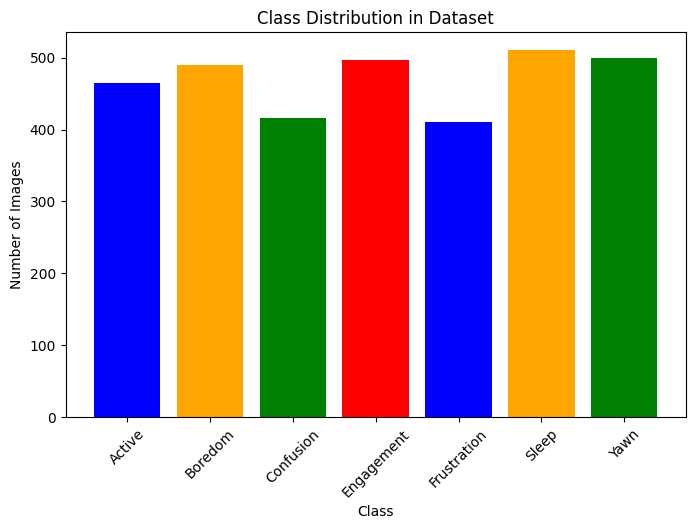

In [4]:
class_names = ['Active', 'Boredom', 'Confusion', 'Engagement', 'Frustration', 'Sleep', 'Yawn']
DATASET_PATH = "data"

# Count images per class
class_counts = {class_name: len(os.listdir(os.path.join(DATASET_PATH, class_name)))
                for class_name in class_names
                if os.path.isdir(os.path.join(DATASET_PATH, class_name))}

# Print counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)
plt.show()


Average Width: 175.82
Average Height: 197.83


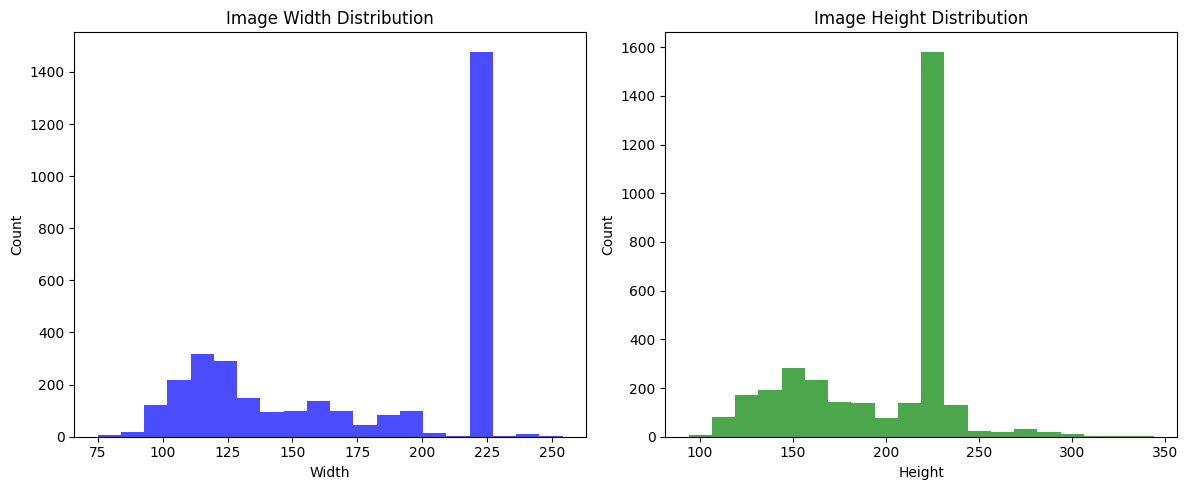

In [ ]:

image_sizes = []

for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):  # Process all images
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  # Append (width, height)

image_sizes = np.array(image_sizes)

# Calculate average width and height
average_width = np.mean(image_sizes[:, 0])
average_height = np.mean(image_sizes[:, 1])

# Print average dimensions
print(f"Average Width: {average_width:.2f}")
print(f"Average Height: {average_height:.2f}")

# Plot histogram of image widths and heights
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(image_sizes[:, 0], bins=20, color='blue', alpha=0.7)
plt.xlabel("Width")
plt.ylabel("Count")
plt.title("Image Width Distribution")

plt.subplot(1, 2, 2)
plt.hist(image_sizes[:, 1], bins=20, color='green', alpha=0.7)
plt.xlabel("Height")
plt.ylabel("Count")
plt.title("Image Height Distribution")

plt.tight_layout()
plt.show()

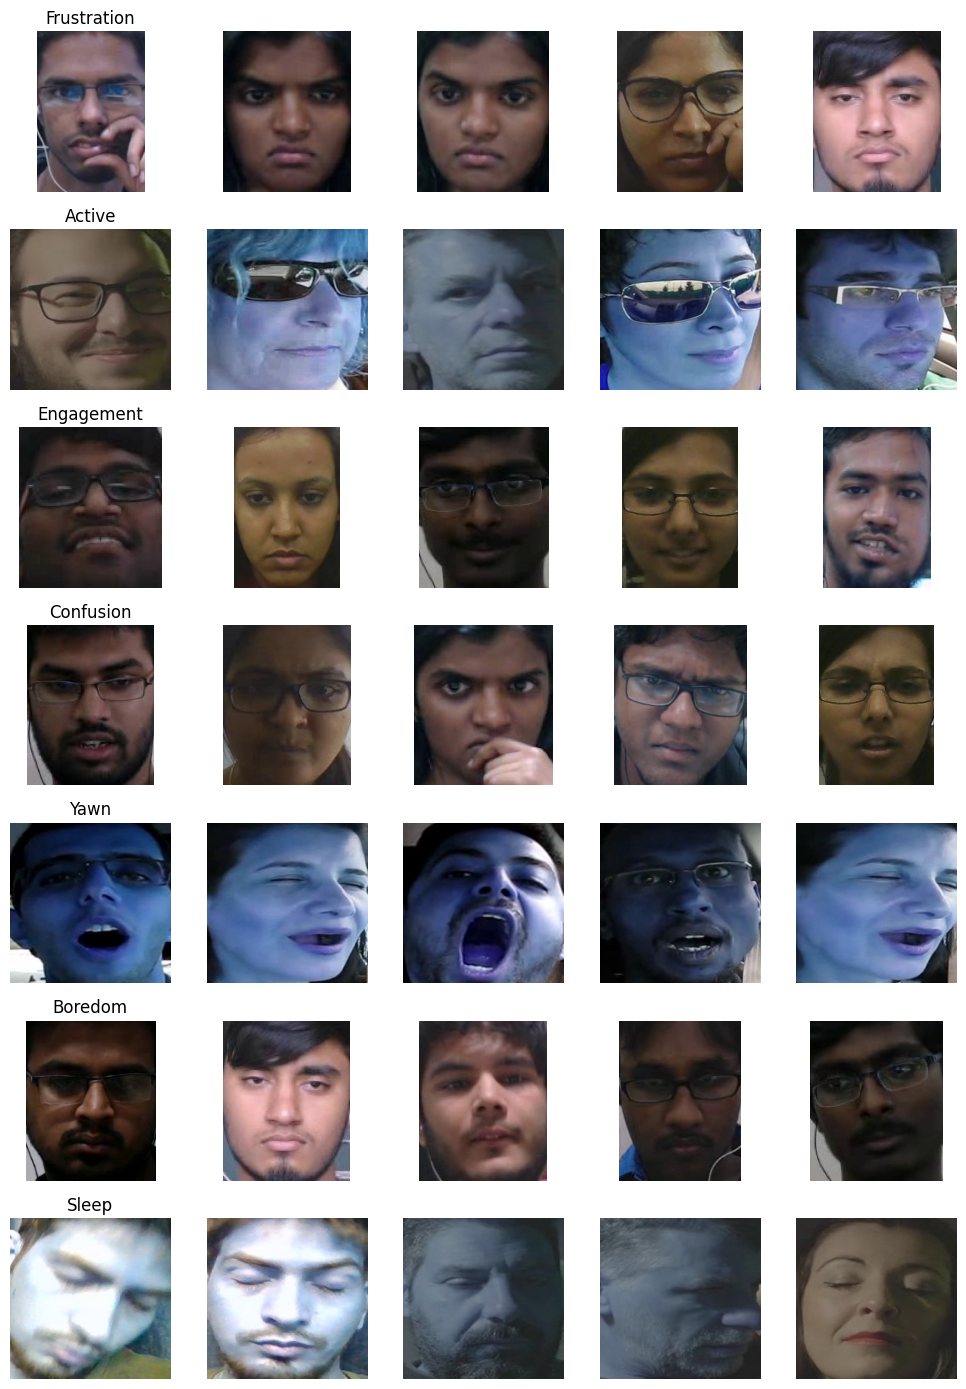

In [ ]:
def show_sample_images(dataset_path, num_samples=5):
    classes = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))]

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 2, len(classes) * 2))

    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_path)
        selected_images = random.sample(image_files, min(num_samples, len(image_files)))

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)  # Read image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name, fontsize=12)

    plt.tight_layout()
    plt.show()

show_sample_images(DATASET_PATH, num_samples=5)


In [6]:
def get_data_generators(data_dir, image_size=(214, 214), batch_size=32, val_split=0.2, seed=42):
    # Augmentation only for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=val_split,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        shear_range=0.15,
        fill_mode='nearest'
    )

    # Only rescaling for validation
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=val_split
    )

    train_gen = train_datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=seed
    )

    val_gen = val_datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=seed
    )

    return train_gen, val_gen


In [7]:

data_dir = "data"
img_size = (224,224)#(180, 180)

def get_sample_images_per_class(data_dir, class_names, num_samples=3):
    samples = []
    for cls in class_names:
        cls_path = os.path.join(data_dir, cls)
        images = os.listdir(cls_path)
        selected = random.sample(images, num_samples)
        for img in selected:
            samples.append((os.path.join(cls_path, img), cls))
    return samples

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = img.astype("float32") / 255.0
    return img

def show_predictions(model, class_names, samples):
    plt.figure(figsize=(16, 14))
    for idx, (img_path, true_label) in enumerate(samples):
        img = preprocess_image(img_path)
        input_tensor = np.expand_dims(img, axis=0)
        preds = model.predict(input_tensor, verbose=0)[0]
        pred_idx = np.argmax(preds)
        pred_label = class_names[pred_idx]
        confidence = preds[pred_idx]

        plt.subplot(7, 5, idx + 1)
        plt.imshow(img[..., ::-1])  # BGR to RGB
        plt.axis('off')
        plt.title(
            f"Actual: {true_label}\nPred: {pred_label} ({confidence:.2f})",
            color='green' if pred_label == true_label else 'red',
            fontsize=10
        )
    plt.tight_layout()
    plt.show()


In [8]:
# Utility methods

def evaluate_model(model, generator, class_names):
    Y_pred = model.predict(generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = generator.classes

    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    print("Cohen’s Kappa Score:", cohen_kappa_score(y_true, y_pred))
    print("Log Loss:", log_loss(y_true, Y_pred))

    try:
        roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), Y_pred, multi_class='ovr')
        print("ROC AUC Score (macro):", roc_auc)
    except:
        print("ROC AUC Score could not be computed.")


def train_model(model, train_gen, val_gen, model_path='best_model.h5', epochs=20):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
        ModelCheckpoint(model_path, save_best_only=True)
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    return model, history


In [9]:
from tensorflow.keras import layers, models, Input

@tf.keras.utils.register_keras_serializable()
def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    return layers.multiply([input_tensor, se])


@tf.keras.utils.register_keras_serializable()
def inception_branch(input_tensor, filters):
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(input_tensor)
    branch5 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(input_tensor)
    merged = layers.concatenate([branch1, branch3, branch5])
    return merged


@tf.keras.utils.register_keras_serializable()
def attention_block(input_tensor):
    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = layers.GlobalMaxPooling2D()(input_tensor)
    concat = layers.concatenate([avg_pool[:, None, None, :], max_pool[:, None, None, :]])
    attention = layers.Conv2D(input_tensor.shape[-1], (1, 1), activation='sigmoid')(concat)
    return layers.multiply([input_tensor, attention])

def build_advanced_fer_model(input_shape=(180, 180, 3), num_classes=7):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)

    # Inception + SE block
    x = inception_branch(x, 32)
    x = se_block(x)

    # Residual connection
    shortcut = layers.Conv2D(x.shape[-1], (1, 1), padding="same")(inputs)
    x = layers.Add()([x, shortcut])

    # Depthwise Separable Conv Block (Efficient)
    x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Attention
    x = attention_block(x)

    # Global Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model


In [10]:
train_gen, val_gen = get_data_generators(DATASET_PATH, image_size=(224, 224))

Found 2631 images belonging to 7 classes.
Found 657 images belonging to 7 classes.


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 87s 693ms/step - accuracy: 0.3843 - loss: 1.5993 - val_accuracy: 0.1263 - val_loss: 1.9335 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 480ms/step - accuracy: 0.5270 - loss: 1.1290 - val_accuracy: 0.1416 - val_loss: 1.8997 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 462ms/step - accuracy: 0.5745 - loss: 0.9717 - val_accuracy: 0.1416 - val_loss: 1.8541 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 465ms/step - accuracy: 0.6008 - loss: 0.9361 - val_accuracy: 0.1355 - val_loss: 2.2460 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - accuracy: 0.6021 - loss: 0.9117 - val_accuracy: 0.1948 - val_loss: 2.1924 - learning_rate: 0.0010
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 461ms/step - accuracy: 0.6123 - loss: 0.8820 - val_accuracy: 0.4231 - val_loss: 1.4731 - learning_rate: 5.0000e-04
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 462ms/step - accuracy: 0.6352 - loss

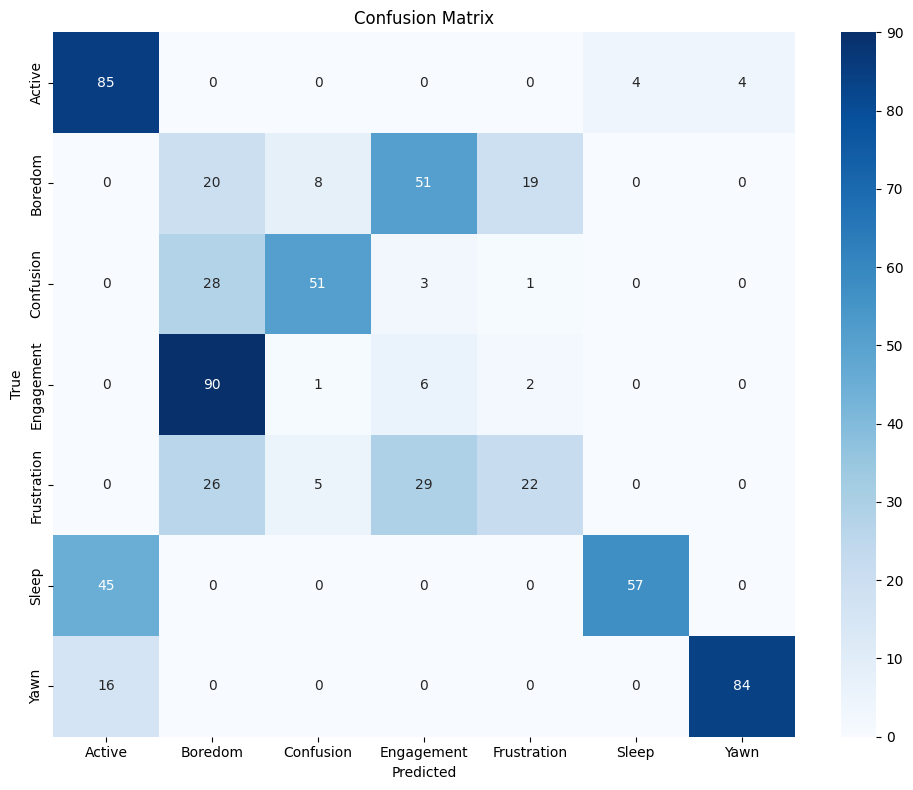

Cohen’s Kappa Score: 0.4091390523969086
Log Loss: 1.37422413954695
ROC AUC Score (macro): 0.8531610368329801


In [ ]:
# Train
model = build_advanced_fer_model(input_shape=(224, 224, 3))
trained_model, history = train_model(model, train_gen, val_gen, epochs=50, model_path='07042025New.keras')
evaluate_model(trained_model, val_gen, class_names)

In [ ]:
model = load_model("07042025New.keras")

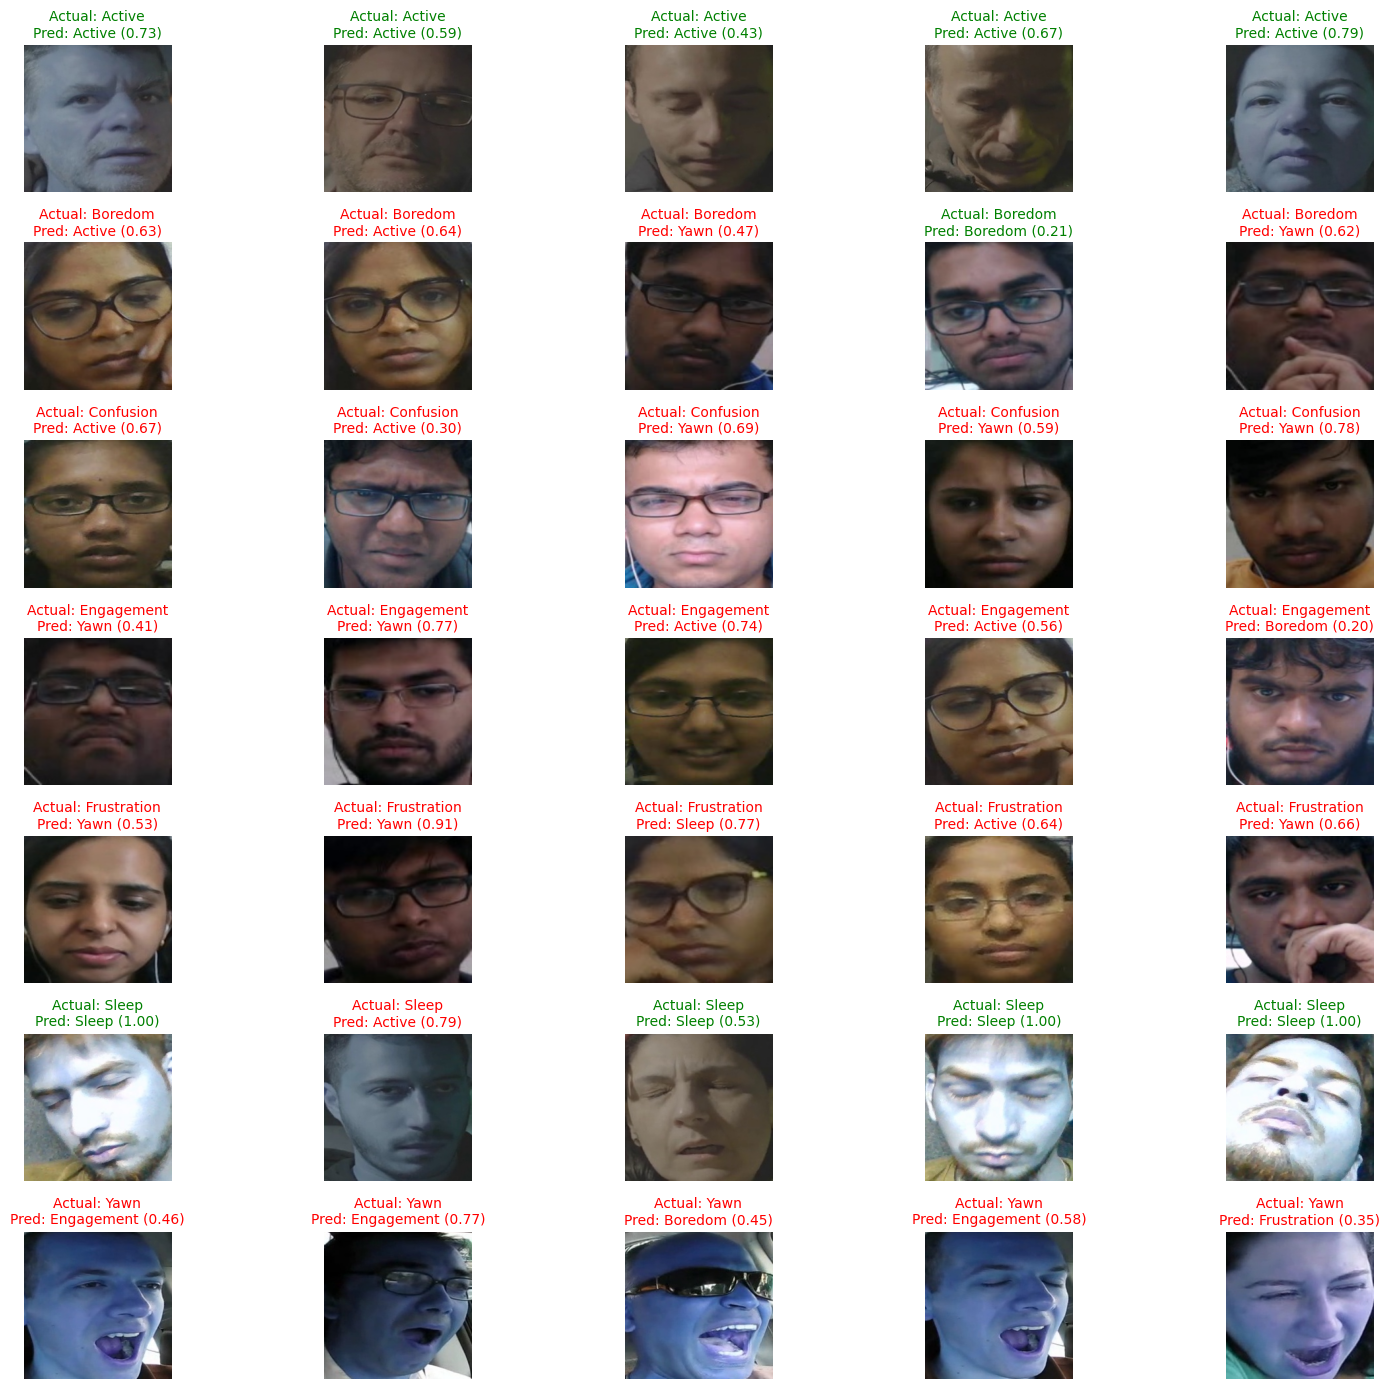

In [ ]:
samples = get_sample_images_per_class(data_dir, class_names, num_samples=5)
show_predictions(model, class_names, samples)


# Model 2

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 7

def build_simple_cnn():
    inputs = keras.Input(shape=INPUT_SHAPE)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Global Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense Layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model


In [16]:
# Train
model = build_simple_cnn()
trained_model, history = train_model(model, train_gen, val_gen, epochs=50, model_path='09042025SimpleCNN.keras')
evaluate_model(trained_model, val_gen, class_names)

Epoch 1/50
 4/83 ━━━━━━━━━━━━━━━━━━━━ 13:07 10s/step - accuracy: 0.2188 - loss: 2.3128

KeyboardInterrupt: 

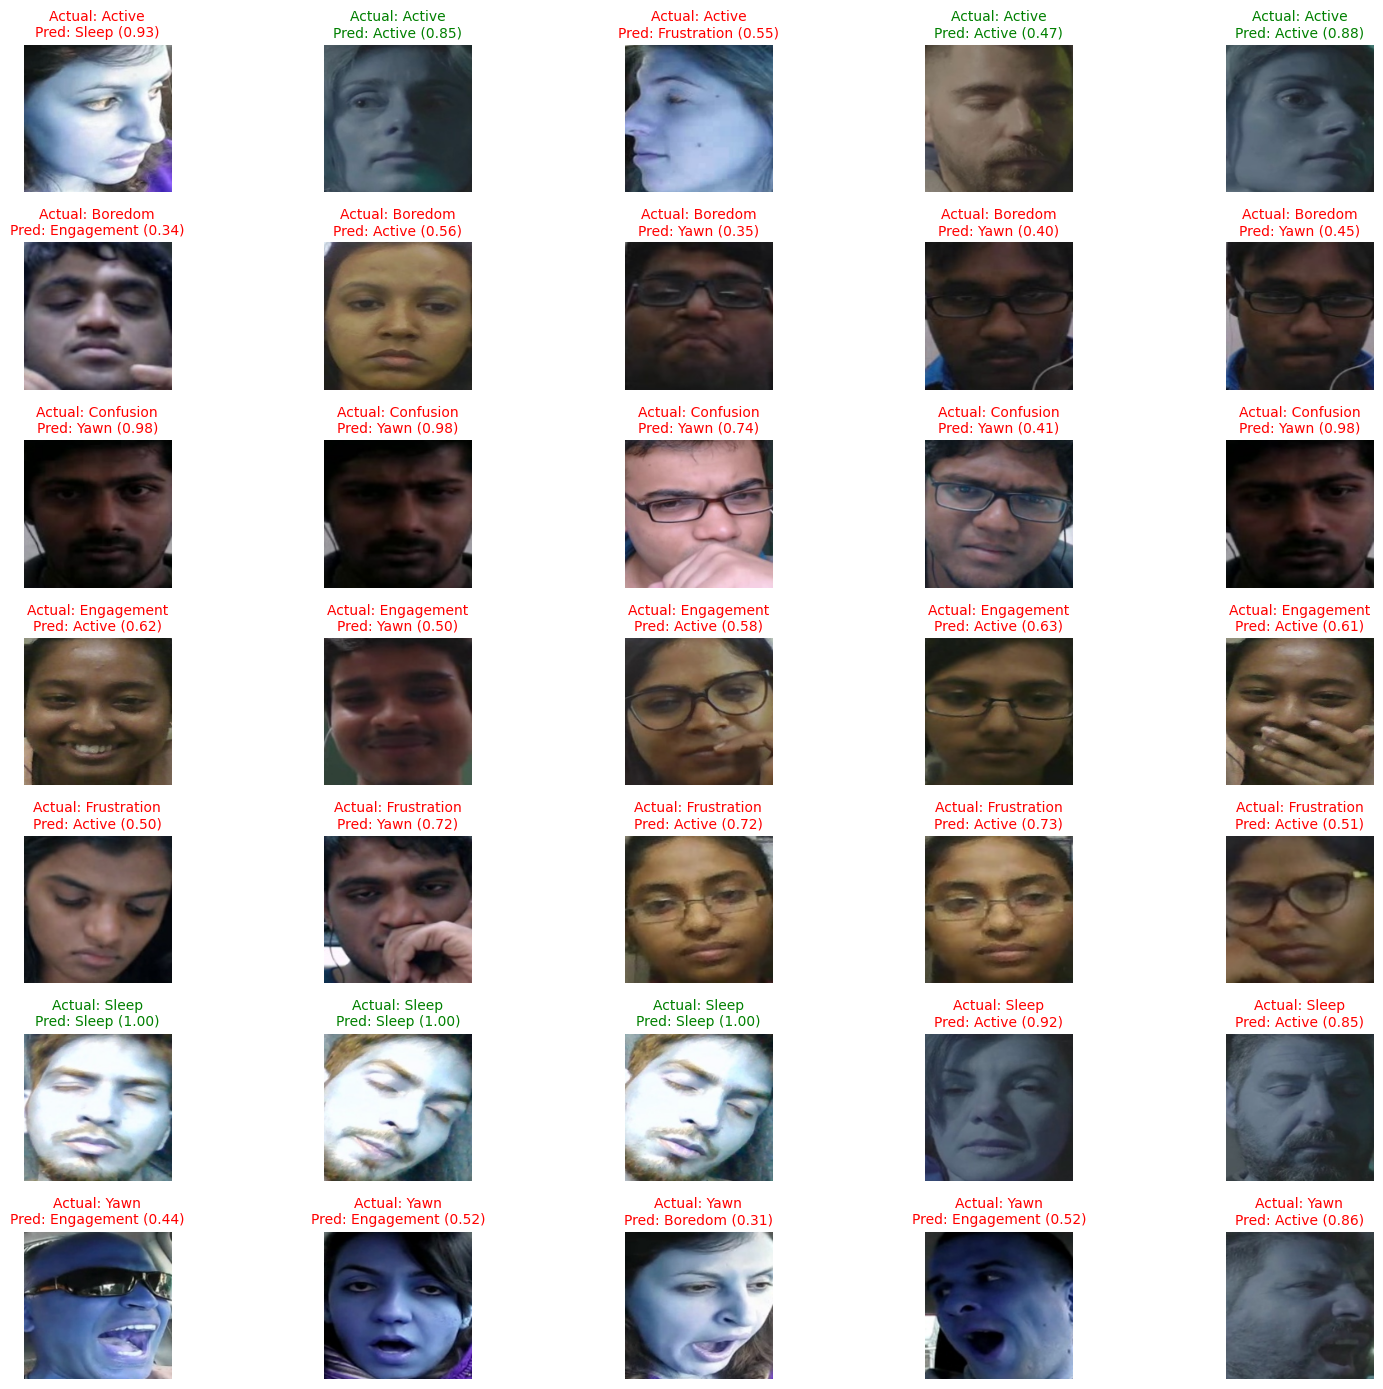

In [ ]:
model = load_model("09042025SimpleCNN.keras")
samples = get_sample_images_per_class(data_dir, class_names, num_samples=5)
show_predictions(model, class_names, samples)


# Model 3

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

def build_efficientnet_transfer_model(input_shape=(180, 180, 3), num_classes=7):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 70s 582ms/step - accuracy: 0.1316 - loss: 2.0130 - val_accuracy: 0.1507 - val_loss: 1.9453 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 336ms/step - accuracy: 0.1526 - loss: 1.9470 - val_accuracy: 0.1492 - val_loss: 1.9438 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 337ms/step - accuracy: 0.1485 - loss: 1.9462 - val_accuracy: 0.1507 - val_loss: 1.9445 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 330ms/step - accuracy: 0.1459 - loss: 1.9448 - val_accuracy: 0.1553 - val_loss: 1.9443 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 333ms/step - accuracy: 0.1705 - loss: 1.9430 - val_accuracy: 0.1553 - val_loss: 1.9439 - learning_rate: 5.0000e-04
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 342ms/step - accuracy: 0.1542 - loss: 1.9438 - val_accuracy: 0.1553 - val_loss: 1.9437 - learning_rate: 5.0000e-04
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 342ms/step - accuracy: 0.1469 - 

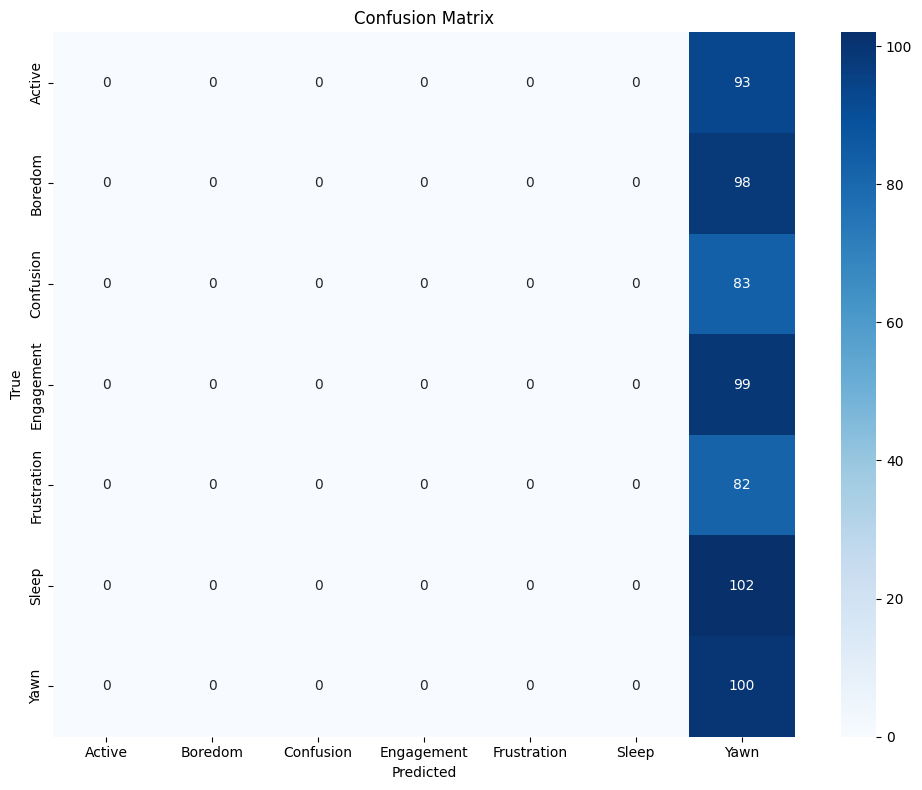

Cohen’s Kappa Score: 0.0
Log Loss: 1.9427171433979704
ROC AUC Score (macro): 0.6966405657977036


In [ ]:
# Train
model = build_efficientnet_transfer_model()
trained_model, history = train_model(model, train_gen, val_gen, epochs=50, model_path="07042025CustomEfficientNet.keras")
evaluate_model(trained_model, val_gen, class_names)

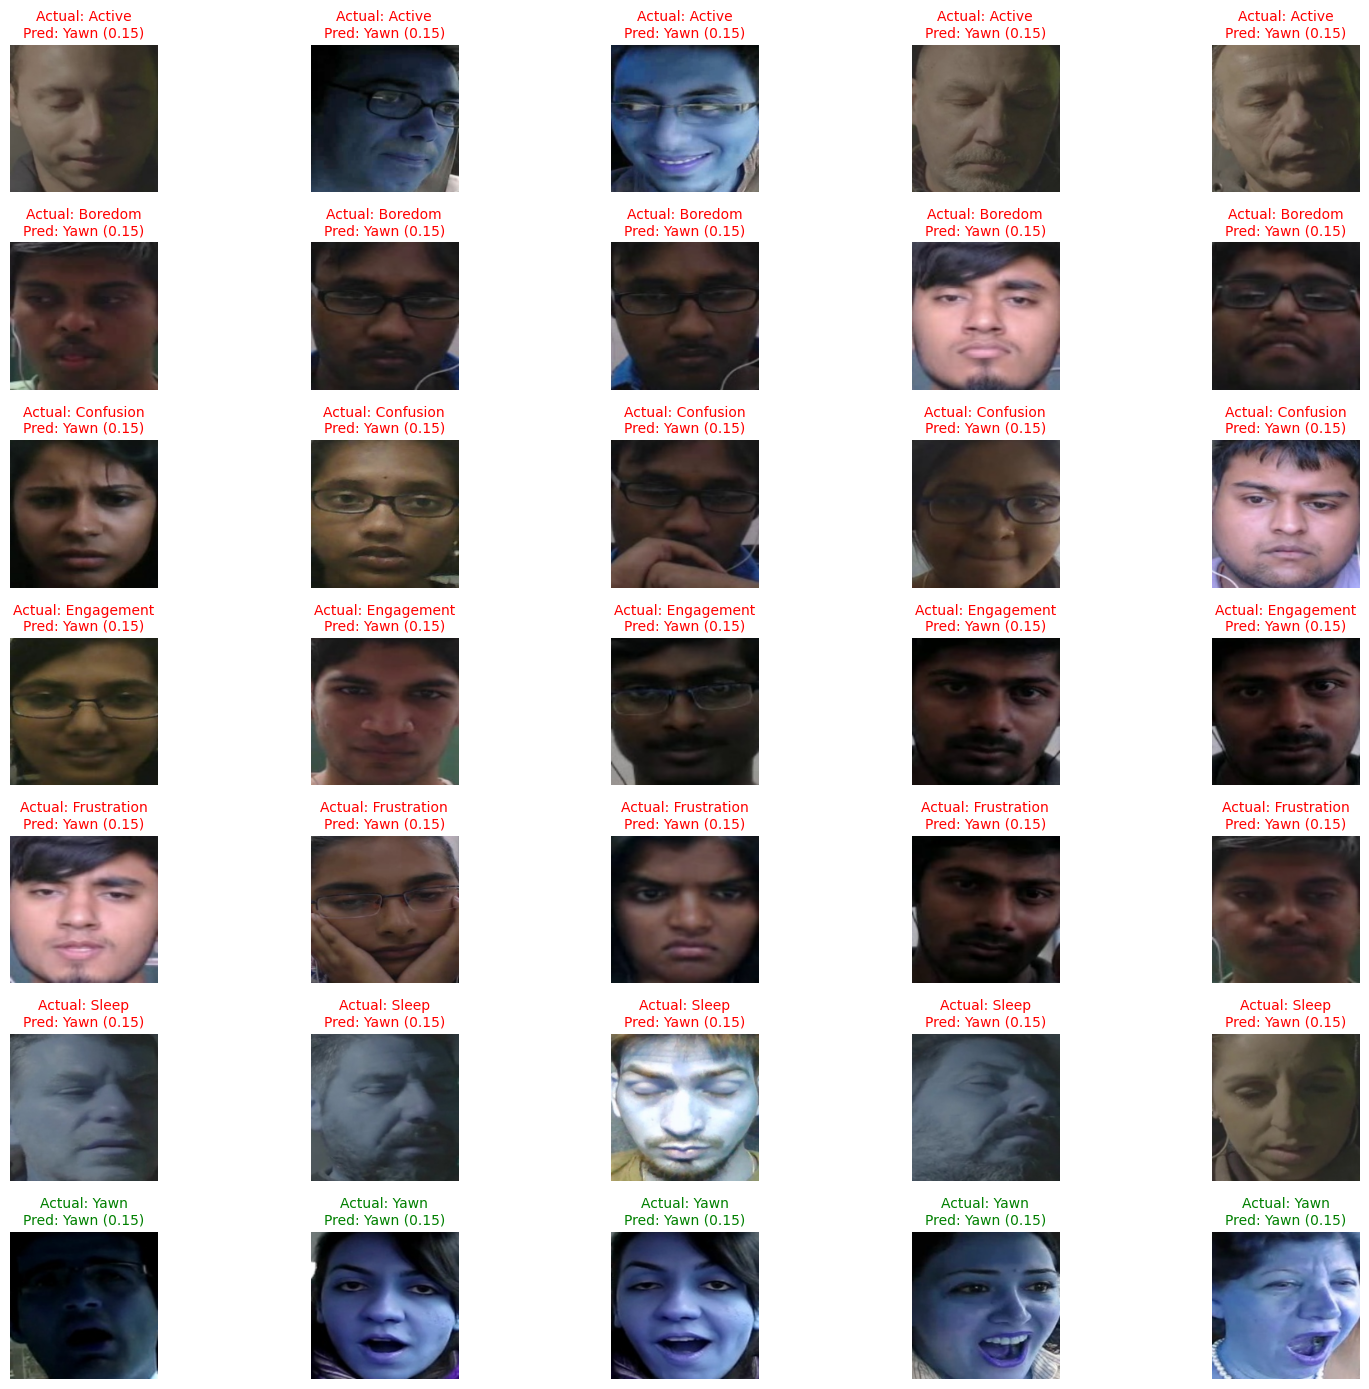

In [ ]:
model = load_model("07042025CustomEfficientNet.keras")
samples = get_sample_images_per_class(data_dir, class_names, num_samples=5)
show_predictions(model, class_names, samples)

# Model 4

In [17]:
def build_minixception(input_shape=(224, 224, 3), num_classes=7):
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, SeparableConv2D
    from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Activation

    input_layer = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for filters in [64, 128, 256]:
        residual = Conv2D(filters, (1, 1), strides=(2, 2), padding='same')(x)
        residual = BatchNormalization()(residual)

        x = SeparableConv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = SeparableConv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
        x = layers.Add()([x, residual])

    x = GlobalAveragePooling2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(input_layer, output)
    return model


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1261s 15s/step - accuracy: 0.4298 - loss: 1.5220 - val_accuracy: 0.1416 - val_loss: 2.0699 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 492ms/step - accuracy: 0.5585 - loss: 1.0420 - val_accuracy: 0.1416 - val_loss: 2.2531 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 481ms/step - accuracy: 0.5943 - loss: 1.0473 - val_accuracy: 0.1659 - val_loss: 2.6202 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - accuracy: 0.5988 - loss: 0.9424 - val_accuracy: 0.2466 - val_loss: 2.5402 - learning_rate: 5.0000e-04
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 493ms/step - accuracy: 0.6431 - loss: 0.8732 - val_accuracy: 0.1553 - val_loss: 2.8076 - learning_rate: 5.0000e-04
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 490ms/step - accuracy: 0.6311 - loss: 0.8830 - val_accuracy: 0.2740 - val_loss: 2.1160 - learning_rate: 2.5000e-04
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 494ms/step - accuracy: 0.650

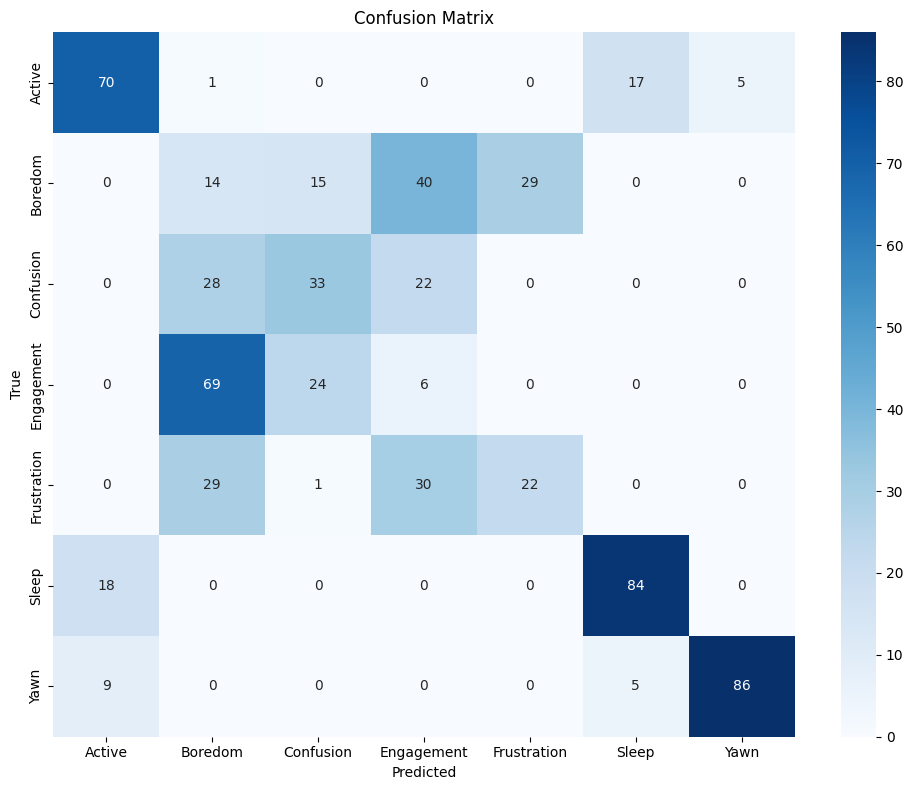

Cohen’s Kappa Score: 0.3909989023051592
Log Loss: 1.232598215754708
ROC AUC Score (macro): 0.8445587799569123


In [ ]:
# Train
model = build_minixception()
trained_model, history = train_model(model, train_gen, val_gen, epochs=50, model_path="09042025MinixCEPTION.keras")
evaluate_model(trained_model, val_gen, class_names)

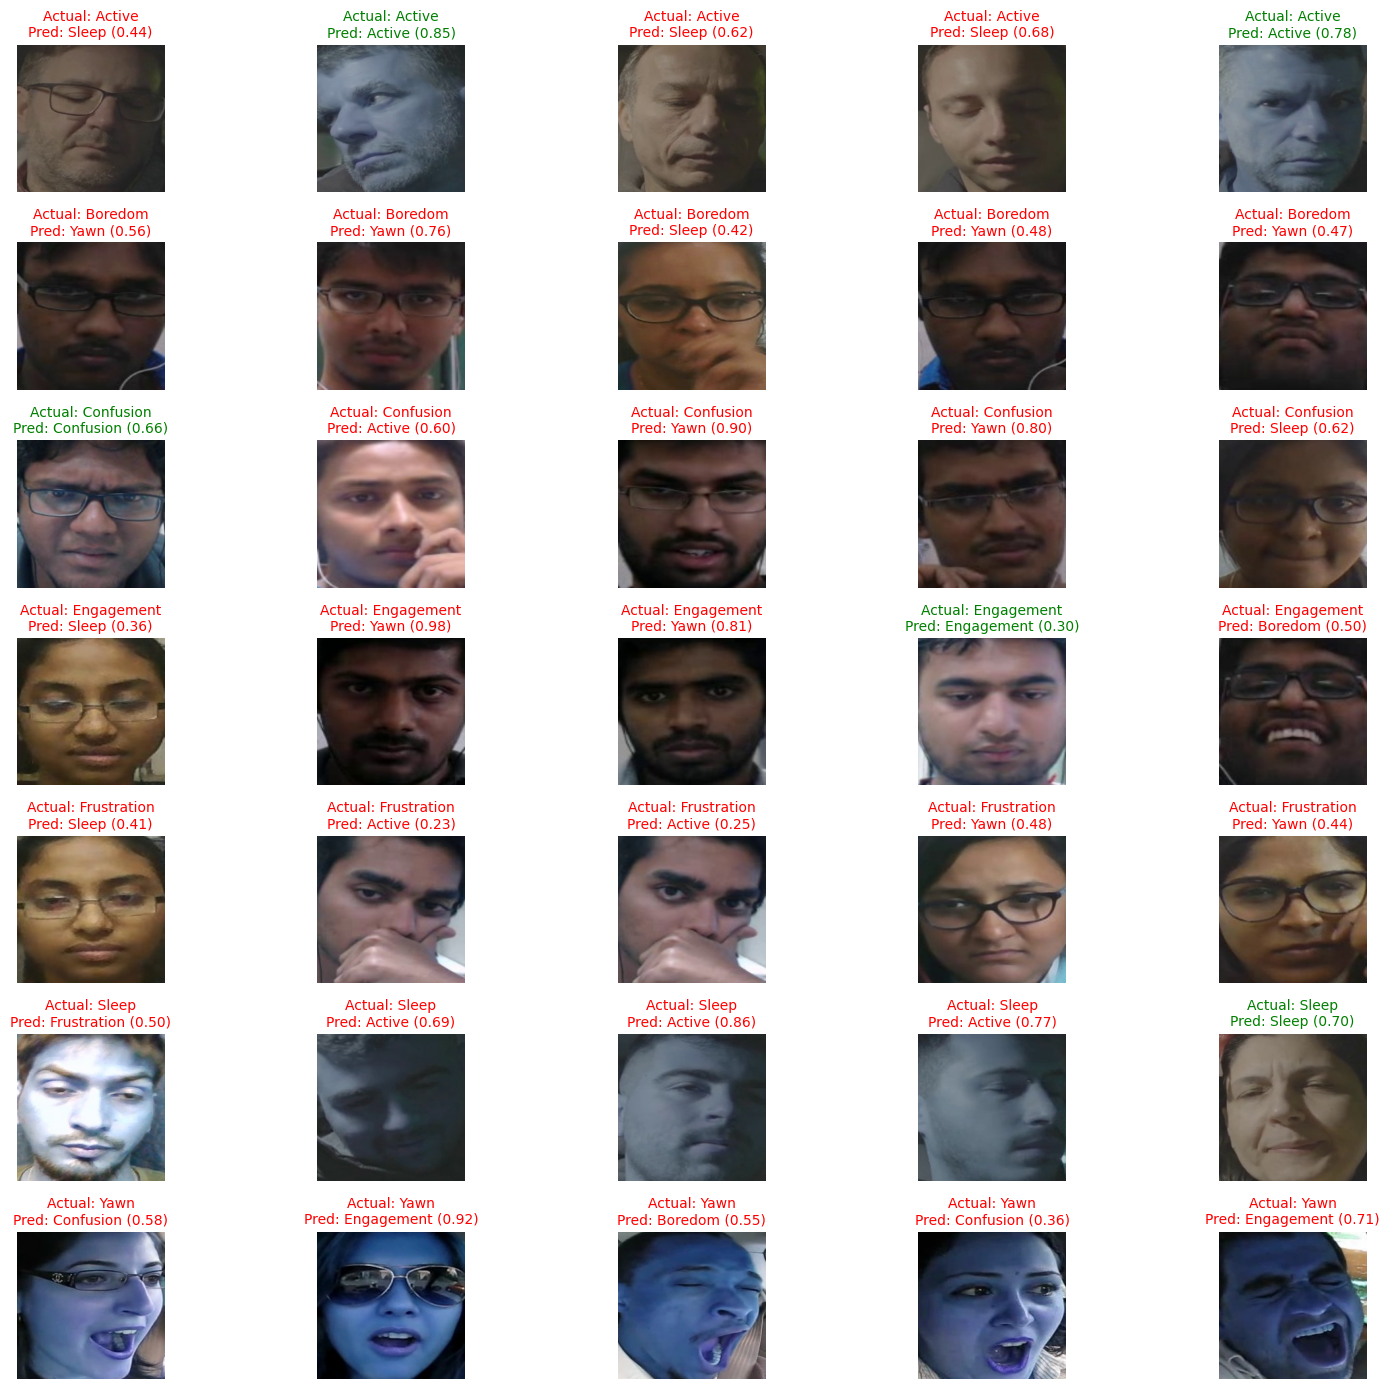

In [ ]:
model = load_model("09042025MinixCEPTION.keras")
samples = get_sample_images_per_class(data_dir, class_names, num_samples=5)
show_predictions(model, class_names, samples)

# Model 5

In [ ]:
def build_quick_cnn(input_shape=(180, 180, 3), num_classes=7):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
# Setup

data_dir = 'data'
class_names = ['Active', 'Boredom', 'Confusion', 'Engagement', 'Frustration', 'Sleep', 'Yawn']
train_gen, val_gen = get_data_generators(data_dir)


Found 2631 images belonging to 7 classes.
Found 657 images belonging to 7 classes.


In [ ]:
# Train
model = build_quick_cnn()
trained_model, history = train_model(model, train_gen, val_gen, epochs=20, model_path="base_model_cnn.h5")

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.2196 - loss: 5.1108

83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 372ms/step - accuracy: 0.2201 - loss: 5.0832 - val_accuracy: 0.3425 - val_loss: 1.6344 - learning_rate: 0.0010
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.2970 - loss: 1.6704

83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 394ms/step - accuracy: 0.2971 - loss: 1.6703 - val_accuracy: 0.4338 - val_loss: 1.5718 - learning_rate: 0.0010
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 29s 342ms/step - accuracy: 0.3203 - loss: 1.6223 - val_accuracy: 0.3196 - val_loss: 1.6264 - learning_rate: 0.0010
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 330ms/step - accuracy: 0.3049 - loss: 1.6266 - val_accuracy: 0.4231 - val_loss: 1.5915 - learning_rate: 0.0010
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.3318 - loss: 1.5604

83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 357ms/step - accuracy: 0.3319 - loss: 1.5603 - val_accuracy: 0.4140 - val_loss: 1.5166 - learning_rate: 5.0000e-04
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.3299 - loss: 1.5375

83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 360ms/step - accuracy: 0.3298 - loss: 1.5376 - val_accuracy: 0.3379 - val_loss: 1.5164 - learning_rate: 5.0000e-04
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.3353 - loss: 1.5131

83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 359ms/step - accuracy: 0.3351 - loss: 1.5133 - val_accuracy: 0.4505 - val_loss: 1.4813 - learning_rate: 5.0000e-04
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.3393 - loss: 1.4918

83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.3393 - loss: 1.4918 - val_accuracy: 0.4003 - val_loss: 1.4789 - learning_rate: 5.0000e-04
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.3667 - loss: 1.4688

83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 359ms/step - accuracy: 0.3667 - loss: 1.4687 - val_accuracy: 0.4795 - val_loss: 1.4321 - learning_rate: 5.0000e-04
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 331ms/step - accuracy: 0.3579 - loss: 1.4651 - val_accuracy: 0.3683 - val_loss: 1.4346 - learning_rate: 5.0000e-04
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.3750 - loss: 1.4257

83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 367ms/step - accuracy: 0.3749 - loss: 1.4257 - val_accuracy: 0.4155 - val_loss: 1.4036 - learning_rate: 5.0000e-04
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.3809 - loss: 1.4099

83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 363ms/step - accuracy: 0.3810 - loss: 1.4098 - val_accuracy: 0.4231 - val_loss: 1.3328 - learning_rate: 5.0000e-04
Epoch 13/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.3977 - loss: 1.3784

83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 362ms/step - accuracy: 0.3976 - loss: 1.3783 - val_accuracy: 0.4353 - val_loss: 1.3079 - learning_rate: 5.0000e-04
Epoch 14/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.3843 - loss: 1.3831

83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 373ms/step - accuracy: 0.3844 - loss: 1.3828 - val_accuracy: 0.5084 - val_loss: 1.2489 - learning_rate: 5.0000e-04
Epoch 15/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 338ms/step - accuracy: 0.4076 - loss: 1.3199 - val_accuracy: 0.4170 - val_loss: 1.3130 - learning_rate: 5.0000e-04
Epoch 16/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 332ms/step - accuracy: 0.4052 - loss: 1.3479 - val_accuracy: 0.4368 - val_loss: 1.2700 - learning_rate: 5.0000e-04
Epoch 17/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.4348 - loss: 1.2708

83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 360ms/step - accuracy: 0.4345 - loss: 1.2711 - val_accuracy: 0.4962 - val_loss: 1.2207 - learning_rate: 2.5000e-04
Epoch 18/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.4137 - loss: 1.2920

83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 359ms/step - accuracy: 0.4138 - loss: 1.2920 - val_accuracy: 0.5145 - val_loss: 1.2104 - learning_rate: 2.5000e-04
Epoch 19/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.4303 - loss: 1.2844

83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 360ms/step - accuracy: 0.4302 - loss: 1.2845 - val_accuracy: 0.5419 - val_loss: 1.1971 - learning_rate: 2.5000e-04
Epoch 20/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.4510 - loss: 1.2469

83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 365ms/step - accuracy: 0.4509 - loss: 1.2470 - val_accuracy: 0.5510 - val_loss: 1.1769 - learning_rate: 2.5000e-04


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step

Overall Accuracy: 0.5510

Classification Report:

              precision    recall  f1-score   support

      Active       0.70      0.80      0.75        93
     Boredom       0.40      0.35      0.37        98
   Confusion       0.00      0.00      0.00        83
  Engagement       0.30      0.84      0.44        99
 Frustration       0.00      0.00      0.00        82
       Sleep       0.83      0.79      0.81       102
        Yawn       0.99      0.90      0.94       100

    accuracy                           0.55       657
   macro avg       0.46      0.53      0.47       657
weighted avg       0.48      0.55      0.50       657

Confusion Matrix:


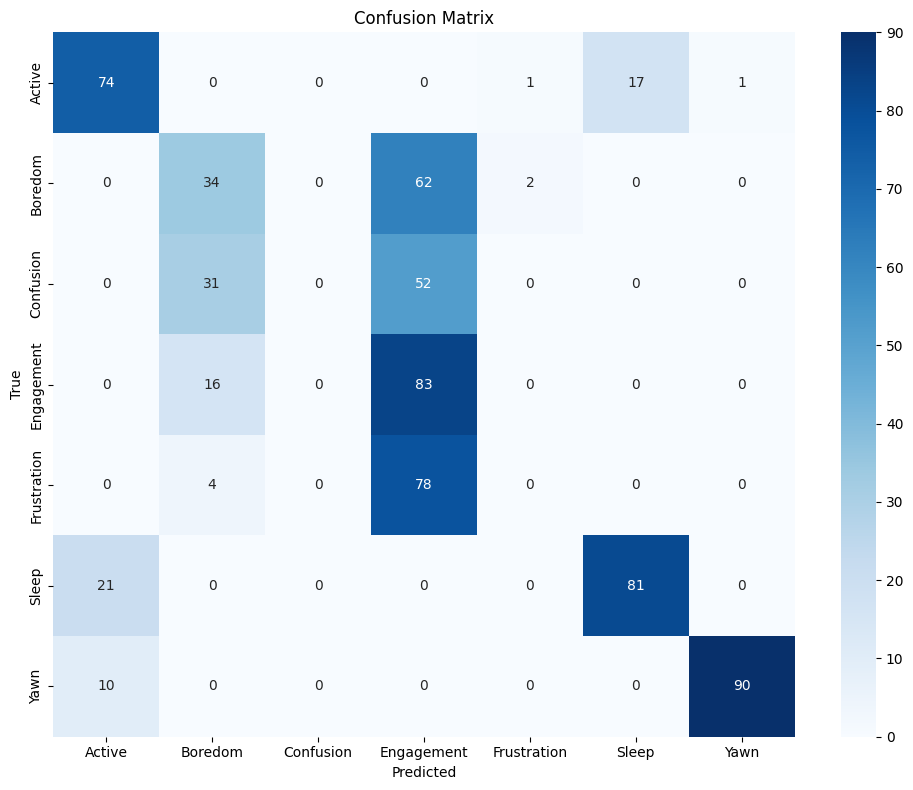

Cohen’s Kappa Score: 0.471875025545864
Log Loss: 1.1769237085494824
ROC AUC Score (macro): 0.8030002193935587


In [ ]:
evaluate_model(trained_model, val_gen, class_names)

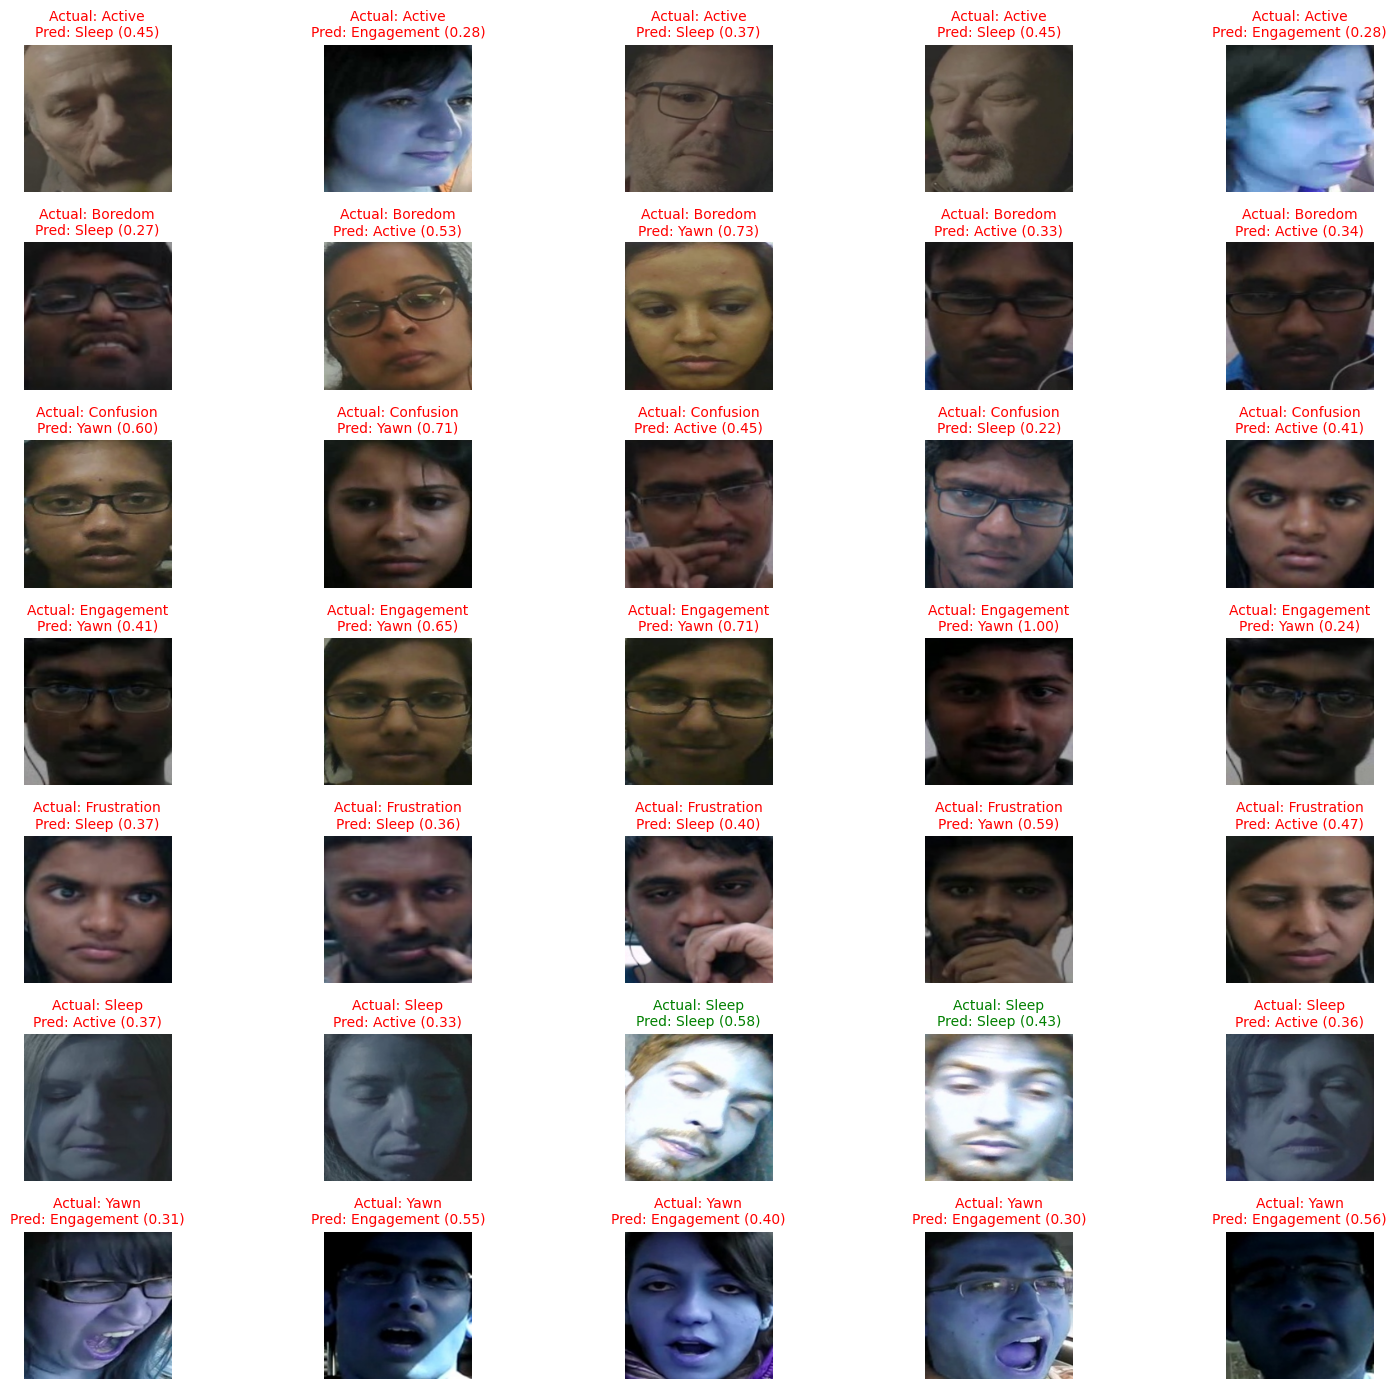

In [ ]:
samples = get_sample_images_per_class(data_dir, class_names, num_samples=5)
show_predictions(trained_model, class_names, samples)
